In [2]:
import numpy as np
from __future__ import division
from IPython.display import Math
import matplotlib.pyplot as mpl

%load_ext Cython


The Cython magic has been moved to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [3]:
Math(r'A = \int_{0}^{1} (1 - x ^ 2) dx')

<IPython.core.display.Math object>

In [4]:
# Cantidad de puntos usados en la integración
N=10000

# Cálculo de la solución analítica de la integral 
A = np.pi/4

# Solución numérica regla de Simpson
x=np.arange(0,1,1/N)
y = np.sqrt(1 - x*x)
An = np.sum(y)/N

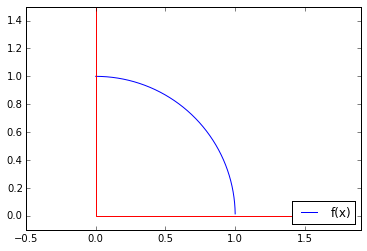

In [5]:
%matplotlib inline
# change axis range for x and y
mpl.xlim([-0.1,1.5])
mpl.ylim([-0.1,1.5])
mpl.axes().set_aspect('equal', 'datalim')
mpl.plot(x,y, label='f(x)' ); mpl.legend(loc='lower right');
mpl.plot([0, 0,1.5], [1.50, 0,0], 'red');


In [6]:
# Integración Montecarlo de 1/4 de círculo
# Generación de los pares (x,y) aleatorios
x,y=(np.random.rand(N),np.random.rand(N))
z=x*x+y*y
#Enmascara si es más grande que 1
z=np.ma.masked_greater(z,1)
#Elimina los enmascarados
z=z.compressed()
#Determina el tamaño del array resultante
Np = z.size
# Cálcula el área
Am = Np/N


print A, Am, An

0.785398163397 0.7863 0.785447869403


Enmascarar y Eliminar datos de un array

http://stackoverflow.com/questions/5927180/removing-data-from-a-numpy-array

In [7]:
N = 10000
Ss=0.01; Sc = 0.1; S=Ss+Sc; CLM = 1/S;
#Espesor de la placa
espH = 1;
global Npas, Nref, Nabs;

In [8]:
def neutron_placa ():
    global Npas, Nref, Nabs
    k=0; u=1; x=0;gmm  = 1
    while (True):
        u = 2*gmm -1
        lmbd = -1*np.log(gmm)/S
        x = (x  + lmbd*u)
        if x > espH:
            Npas = Npas + 1; break;
        else:
            if x < 0:
                Nref = Nref + 1; break;
            else:
                if gmm < Sc/S:
                    Nabs = Nabs + 1; break
                else:
                    k = k + 1
                    gmm  = np.random.random()
                    #u = 2*gmm - 1
  
global Npas, Nref, Nabs
Npas = Nref = Nabs = 0;
for j in range (0,N):
    neutron_placa ()

print Npas/N, Nref/N, Nabs/N, (Npas+ Nref+ Nabs)/N

0.2793 0.5401 0.1806 1.0


In [9]:
%%cython

cimport cython

from libc.stdlib cimport rand, srand
from libc.time cimport time, time_t
from libc.math cimport  log

cdef extern from "stdlib.h":
  cdef int RAND_MAX

@cython.cdivision(True)
def init_rand ():    
   cdef time_t seconds  
   time(&seconds)
   srand(<unsigned int>seconds)

@cython.cdivision(True)
def neutron_placa_c (float Sc, float S, float espH ):
    cdef int Npas = 0
    cdef int Nref = 0
    cdef int Nabs = 0
        
    cdef int k = 0; 
    cdef float u=1, x=0, gmm  = 1
     
    while (True):
        u = 2*gmm -1
        lmbd = -1*log(gmm)/S
        x = (x  + lmbd*u)
        if x > espH:
            Npas = Npas + 1; break;
        else:
            if x < 0:
                Nref = Nref + 1; break;
            else:
                if gmm < Sc/S:
                    Nabs = Nabs + 1; break
                else:
                    k = k + 1
                    gmm  = <float>rand()/<float>RAND_MAX
    return Npas, Nref, Nabs

In [10]:
import numpy as np
global Npas, Nref, Nabs, np
N = 10000
Npas = Nref = Nabs = 0;
salida = np.zeros((3,N))
for j in range (0,N):
  (pas, ref, abs ) = neutron_placa_c(Sc, S, espH)
  Npas +=pas; Nref += ref; Nabs += abs
  salida[(0,j)] = Npas/(j +1.5)
  salida[(1,j)] = Nref/(j+1.5)
  salida[(2,j)] = Nabs/(j+1.5)
maxs =[Npas/N, Nref/N, Nabs/N]
print maxs

[0.274, 0.5527, 0.1733]


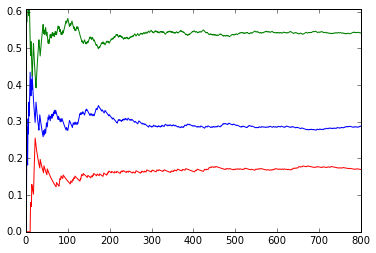

In [11]:
mpl.xlim ([0,800])
mpl.ylim([0, 1.1*np.max(maxs)])
mpl.plot(salida[(0)])
mpl.plot(salida[(1)])
mpl.plot(salida[(2)]);

In [22]:
window = 10
weights = np.repeat(1.0, window)/window
sma0 = np.convolve(salida[(0)], weights, 'valid')
sma1 = np.convolve(salida[(1)], weights, 'valid')
sma2 = np.convolve(salida[(2)], weights, 'valid')

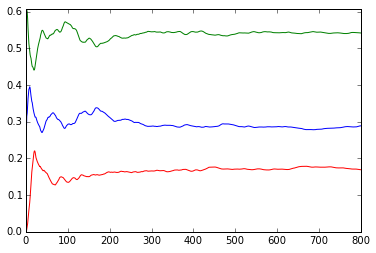

In [25]:
mpl.xlim ([0,800])
mpl.ylim([0, 1.1*np.max(maxs)])
mpl.plot(sma0) 
mpl.plot(sma1)
mpl.plot(sma2);